In [766]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pickle as pk


In [797]:
# Load your dataset (adjust the path if needed)
df = pd.read_csv('all_data.csv')
# Set the Date column as the index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [796]:
df

,gold_Close,silver_Price,sp500_Price,gold_price_yesterday,cpi_CPI,ppi_PPI,m1sl_M1SL,dollar_rate_Price,is_holiday,target_day_1,...,target_day_21,target_day_22,target_day_23,target_day_24,target_day_25,target_day_26,target_day_27,target_day_28,target_day_29,target_day_30
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-03,119.290001,20.211,1831.40,118.000000,234.100,201.200,2638.8,80.79,0,119.500000,...,120.089996,121.320000,120.989998,121.290001,121.239998,122.169998,122.919998,124.360001,124.430000,125.489998
2014-01-06,119.500000,20.103,1826.80,119.290001,234.100,201.200,2638.8,80.65,0,118.820000,...,121.320000,120.989998,121.290001,121.239998,122.169998,122.919998,124.360001,124.430000,125.489998,127.150002
2014-01-07,118.820000,19.787,1837.90,119.500000,234.100,201.200,2638.8,80.83,0,118.120003,...,120.989998,121.290001,121.239998,122.169998,122.919998,124.360001,124.430000,125.489998,127.150002,127.150002
2014-01-08,118.120003,19.539,1837.50,118.820000,234.100,201.200,2638.8,81.02,0,118.459999,...,121.290001,121.239998,122.169998,122.919998,124.360001,124.430000,125.489998,127.150002,127.150002,127.400002
2014-01-09,118.459999,19.683,1838.10,118.120003,234.100,201.200,2638.8,81.00,0,120.260002,...,121.239998,122.169998,122.919998,124.360001,124.430000,125.489998,127.150002,127.150002,127.400002,126.269997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-16,228.289993,31.458,5667.20,223.830002,313.207,256.772,17978.9,104.27,0,227.229996,...,228.059998,226.199997,226.910004,231.990005,231.610001,232.460007,232.149994,229.369995,232.020004,232.759995
2024-07-17,227.229996,30.377,5588.27,228.289993,313.207,256.772,17978.9,103.75,0,225.779999,...,226.199997,226.910004,231.990005,231.610001,232.460007,232.149994,229.369995,232.020004,232.759995,233.389999
2024-07-18,225.779999,30.224,5544.59,227.229996,313.207,256.772,17978.9,104.17,0,221.729996,...,226.910004,231.990005,231.610001,232.460007,232.149994,229.369995,232.020004,232.759995,233.389999,231.750000


Data Preprocessing - checking correlation and cointegration

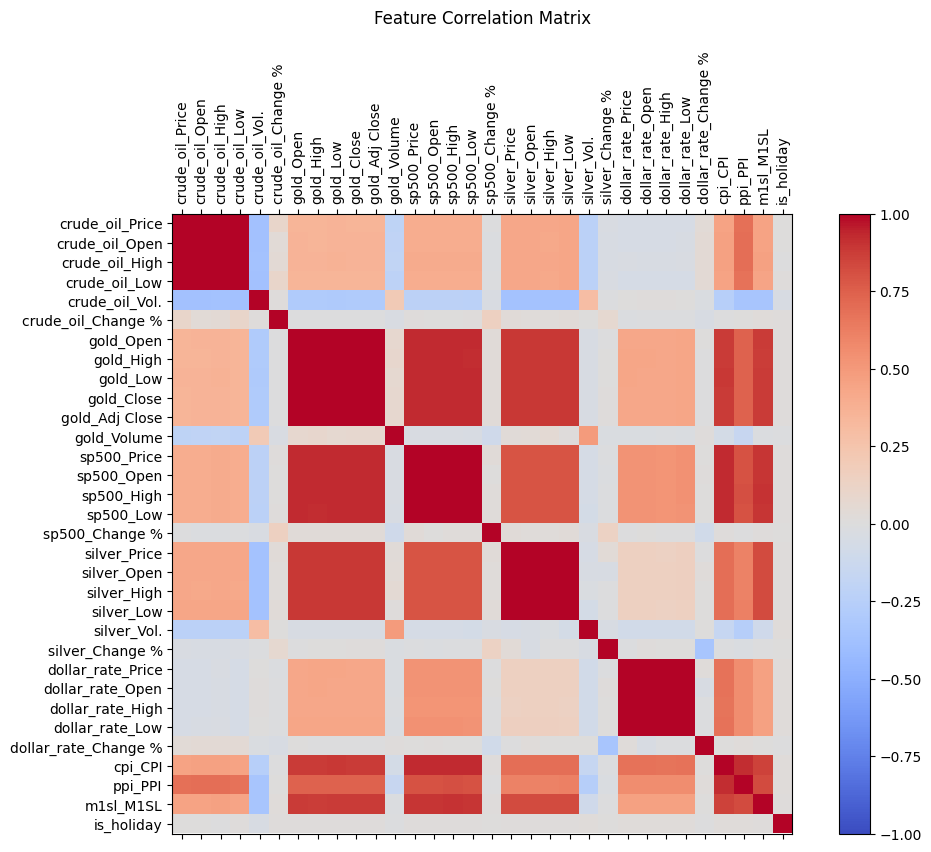

In [799]:
import matplotlib.pyplot as plt

def plot_corr_matrix(df):
    correlation_matrix = df.corr()
    
    # Plotting the correlation matrix with Matplotlib
    plt.figure(figsize=(12, 8))
    plt.matshow(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1, fignum=1)
    plt.colorbar()
    
    # Set tick labels for the correlation matrix
    plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation=90)
    plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns)
    
    # Annotate each cell with the numeric value of the correlation
    """for i in range(len(correlation_matrix.columns)):
        for j in range(len(correlation_matrix.columns)):
            plt.text(j, i, f"{correlation_matrix.iloc[i, j]:.2f}", ha='center', va='center', color='black')
    """
    plt.title("Feature Correlation Matrix", pad=20)
    plt.show()

plot_corr_matrix(df)

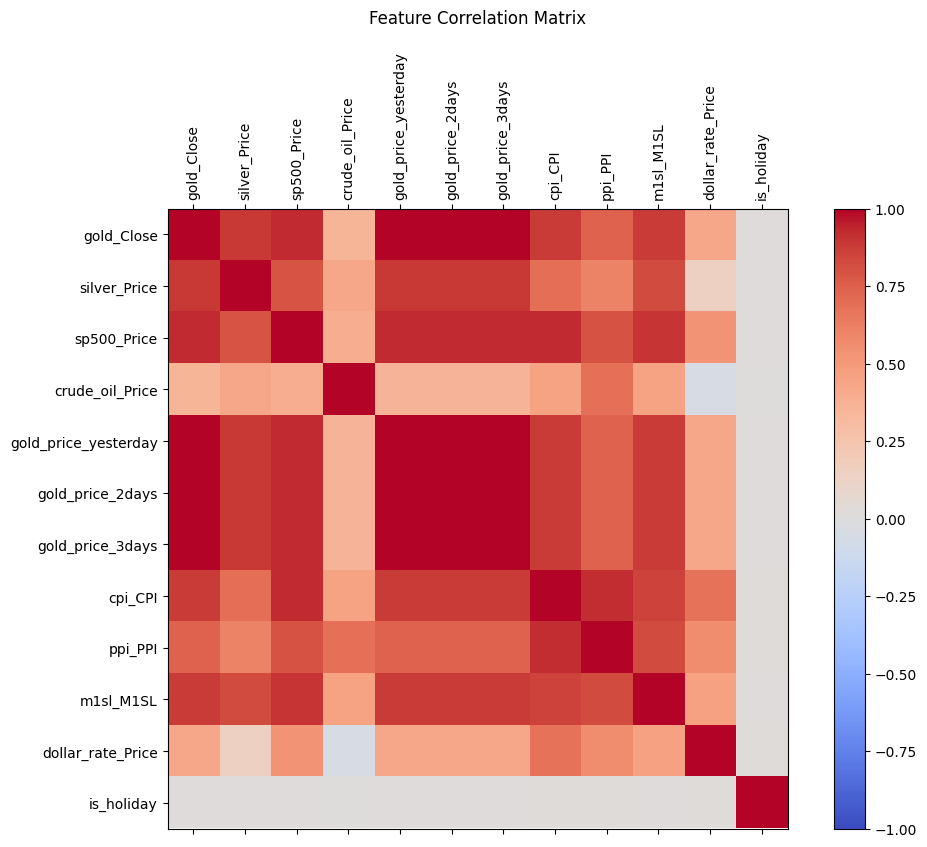

In [800]:
df['gold_price_yesterday'] = df['gold_Close'].shift(1)
df['gold_price_2days'] = df['gold_Close'].shift(2)
df['gold_price_3days'] = df['gold_Close'].shift(3)
df = df[['gold_Close', 'silver_Price', 'sp500_Price', 'crude_oil_Price', 'gold_price_yesterday', 'gold_price_2days', 'gold_price_3days','cpi_CPI', 'ppi_PPI', 'm1sl_M1SL', 'dollar_rate_Price','is_holiday']]
plot_corr_matrix(df)

In [801]:
df

,gold_Close,silver_Price,sp500_Price,crude_oil_Price,gold_price_yesterday,gold_price_2days,gold_price_3days,cpi_CPI,ppi_PPI,m1sl_M1SL,dollar_rate_Price,is_holiday
Date,,,,,,,,,,,,
2014-01-01,NaN,NaN,NaN,98.70,NaN,NaN,NaN,234.100,201.200,2638.8,80.03,1
2014-01-02,118.000000,20.128,1832.00,95.44,NaN,NaN,NaN,234.100,201.200,2638.8,80.63,0
2014-01-03,119.290001,20.211,1831.40,93.96,118.000000,NaN,NaN,234.100,201.200,2638.8,80.79,0
2014-01-06,119.500000,20.103,1826.80,93.43,119.290001,118.000000,NaN,234.100,201.200,2638.8,80.65,0
2014-01-07,118.820000,19.787,1837.90,93.67,119.500000,119.290001,118.000000,234.100,201.200,2638.8,80.83,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-26,232.759995,27.715,5472.73,75.56,232.020004,229.369995,232.149994,313.207,256.772,17978.9,104.66,0
2024-08-27,233.389999,27.715,5472.73,75.56,232.759995,232.020004,229.369995,313.207,256.772,17978.9,104.66,0
2024-08-28,231.750000,27.715,5472.73,75.56,233.389999,232.759995,232.020004,313.207,256.772,17978.9,104.66,0


In [781]:
df = df[['gold_Close', 'silver_Price', 'sp500_Price','gold_price_yesterday','cpi_CPI', 'ppi_PPI', 'm1sl_M1SL', 'dollar_rate_Price','is_holiday']]
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Add constant to the data (for calculating VIF)
X = add_constant(df.drop('gold_Close', axis=1))
X = X.dropna()

# Calculate VIF for each feature
vif = pd.DataFrame()
vif['Feature'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display VIF
print(vif)

                Feature         VIF
0                 const  858.983094
1          silver_Price    8.403596
2           sp500_Price   14.283230
3  gold_price_yesterday   18.841957
4               cpi_CPI   46.780866
5               ppi_PPI   14.153920
6             m1sl_M1SL    9.644946
7     dollar_rate_Price    3.845265
8            is_holiday    1.001670


In [782]:
# adding columns to predict - dependent on number of days
#df = df[['gold_Close', 'silver_Price', 'sp500_Price','gold_price_yesterday', 'gold_price_2days', 'gold_price_3days','cpi_CPI', 'ppi_PPI', 'm1sl_M1SL', 'dollar_rate_Price','is_holiday']]

num_days = 30 # Number of days to predict
# Prepare target columns for x-day predictions
for i in range(1, num_days + 1):
    df[f'target_day_{i}'] = df['gold_Close'].shift(-i)

# Drop rows with NaN values from shifting
df = df.dropna()
# Separate features and targets
# filter df to leave only 1 column of each type
X = df.drop(columns=[f'target_day_{i}' for i in range(1, num_days + 1)])
y = df[[f'target_day_{i}' for i in range(1, num_days + 1)]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

X_train_dropped = X_train.dropna()
#print(len(X_train_dropped))
y_train_dropped = y_train.loc[X_train_dropped.index]

# Drop rows with NaN in X_test and y_test
X_test_dropped = X_test.dropna()
y_test_dropped = y_test.loc[X_test_dropped.index]

# Ensure that y_test_dropped does not contain NaN values
X_test_dropped = X_test_dropped.dropna()
y_test_dropped = y_test_dropped.dropna()

# Check if indices still match after dropping NaNs
common_index = X_test_dropped.index.intersection(y_test_dropped.index)
X_test_dropped = X_test_dropped.loc[common_index]
y_test_dropped = y_test_dropped.loc[common_index]

X

,gold_Close,silver_Price,sp500_Price,gold_price_yesterday,cpi_CPI,ppi_PPI,m1sl_M1SL,dollar_rate_Price,is_holiday
Date,,,,,,,,,
2014-01-03,119.290001,20.211,1831.40,118.000000,234.100,201.200,2638.8,80.79,0
2014-01-06,119.500000,20.103,1826.80,119.290001,234.100,201.200,2638.8,80.65,0
2014-01-07,118.820000,19.787,1837.90,119.500000,234.100,201.200,2638.8,80.83,0
2014-01-08,118.120003,19.539,1837.50,118.820000,234.100,201.200,2638.8,81.02,0
2014-01-09,118.459999,19.683,1838.10,118.120003,234.100,201.200,2638.8,81.00,0
...,...,...,...,...,...,...,...,...,...
2024-07-16,228.289993,31.458,5667.20,223.830002,313.207,256.772,17978.9,104.27,0
2024-07-17,227.229996,30.377,5588.27,228.289993,313.207,256.772,17978.9,103.75,0
2024-07-18,225.779999,30.224,5544.59,227.229996,313.207,256.772,17978.9,104.17,0


In [783]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


# Ridge Regression (L2 regularization)
ridge_model = Ridge(alpha=1.0)  # Alpha is the regularization strength
ridge_model.fit(X_train_dropped, y_train_dropped)
ridge_preds = ridge_model.predict(X_test)
ridge_rmse = mean_squared_error(y_test, ridge_preds, squared=False)
print(f"Ridge RMSE: {ridge_rmse}")

# Lasso Regression (L1 regularization)
lasso_model = Lasso(alpha=0.1)
lasso_model.fit(X_train, y_train)
lasso_preds = lasso_model.predict(X_test)
lasso_rmse = mean_squared_error(y_test, lasso_preds, squared=False)
print(f"Lasso RMSE: {lasso_rmse}")

/Library/Python/3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Library/Python/3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.252e+03, tolerance: 1.276e+02
  model = cd_fast.enet_coordinate_descent(
/Library/Python/3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.104e+02, tolerance: 1.278e+02
  model = cd_fast.enet_coordinate_descent(
/Library/Python/3.9/site-packages/sklearn/linear_model/_coor

Ridge RMSE: 7.335562478415181


/Library/Python/3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.103e+04, tolerance: 1.285e+02
  model = cd_fast.enet_coordinate_descent(
/Library/Python/3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.223e+04, tolerance: 1.286e+02
  model = cd_fast.enet_coordinate_descent(
/Library/Python/3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.275e+04, tolerance: 1.287e+02
  model = cd_f

Lasso RMSE: 7.281173186437546


/Library/Python/3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.301e+04, tolerance: 1.292e+02
  model = cd_fast.enet_coordinate_descent(
/Library/Python/3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.757e+03, tolerance: 1.293e+02
  model = cd_fast.enet_coordinate_descent(
/Library/Python/3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [784]:
from sklearn.feature_selection import RFE

model = LinearRegression()

# Apply RFE
selector = RFE(model, n_features_to_select=20)  # Choose how many features to select
selector = selector.fit(X_train, y_train)

# Get the selected features
selected_features = X.columns[selector.support_]
print(f"Selected features: {selected_features}")

# Train model with selected features
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]
model.fit(X_train_selected, y_train)
y_pred_selected = model.predict(X_test_selected)

# Evaluate the model
rmse_selected = mean_squared_error(y_test, y_pred_selected, squared=False)

Selected features: Index(['gold_Close', 'silver_Price', 'sp500_Price', 'gold_price_yesterday',
       'cpi_CPI', 'ppi_PPI', 'm1sl_M1SL', 'dollar_rate_Price', 'is_holiday'],
      dtype='object')


/Library/Python/3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [787]:
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor

# Fit the MultiOutputRegressor
model = MultiOutputRegressor(LinearRegression())
#model = LinearRegression()
model.fit(X_train_dropped, y_train_dropped)

# Initialize list to hold summary data for each target day
summary_data = []

# Extract feature names from X_train_dropped
feature_names = X_train_dropped.columns

# For each target day, get the model's coefficients, intercept, and performance metrics
for day_index, estimator in enumerate(model.estimators_):
    # Get coefficients as a Series with feature names
    coefficients = pd.Series(estimator.coef_, index=feature_names)
    intercept = estimator.intercept_
    
    # Calculate predictions and performance metrics
    y_pred = estimator.predict(X_train_dropped)
    mse = mean_squared_error(y_train_dropped.iloc[:, day_index], y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_train_dropped.iloc[:, day_index], y_pred)

    # Create a DataFrame for the day's coefficients with metrics included
    day_summary = pd.DataFrame({
        'Coefficient': coefficients,
        'Intercept': intercept,
        'MSE': mse,
        'RMSE': rmse,
        'R^2': r2,
    })
    summary_data.append(day_summary)

# Concatenate all day summaries into a single DataFrame for display
summary_df = pd.concat(summary_data, keys=[f'Target Day {i+1}' for i in range(len(summary_data))])

# Set display options to show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Show the full summary with feature names and coefficients
print("Detailed Coefficients Summary for Each Target Day:")
#print(summary_df)

# Reset display options to default after viewing if needed
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')
summary_df

Detailed Coefficients Summary for Each Target Day:


Coefficient  Intercept        MSE  \
Target Day 1  gold_Close               1.014436   3.269035   1.471237   
              silver_Price            -0.091402   3.269035   1.471237   
              sp500_Price             -0.000016   3.269035   1.471237   
              gold_price_yesterday    -0.013818   3.269035   1.471237   
              cpi_CPI                  0.003716   3.269035   1.471237   
...                                         ...        ...        ...   
Target Day 30 cpi_CPI                  0.044500  66.338985  28.853001   
              ppi_PPI                 -0.142123  66.338985  28.853001   
              m1sl_M1SL                0.000568  66.338985  28.853001   
              dollar_rate_Price       -0.336375  66.338985  28.853001   
              is_holiday               0.490600  66.338985  28.853001   

                                        RMSE       R^2  
Target Day 1  gold_Close            1.212946  0.997380  
              silver_Price          1.212946  0.997380  
              sp500_Price           1.212946  0.997380  
              gold_price_yesterday  1.212946  0.997380  
              cpi_CPI               1.212946  0.997380  
...                                      ...       ...  
Target Day 30 cpi_CPI               5.371499  0.949385  
              ppi_PPI               5.371499  0.949385  
              m1sl_M1SL             5.371499  0.949385  
              dollar_rate_Price     5.371499  0.949385  
              is_holiday            5.371499  0.949385  

[270 rows x 5 columns]

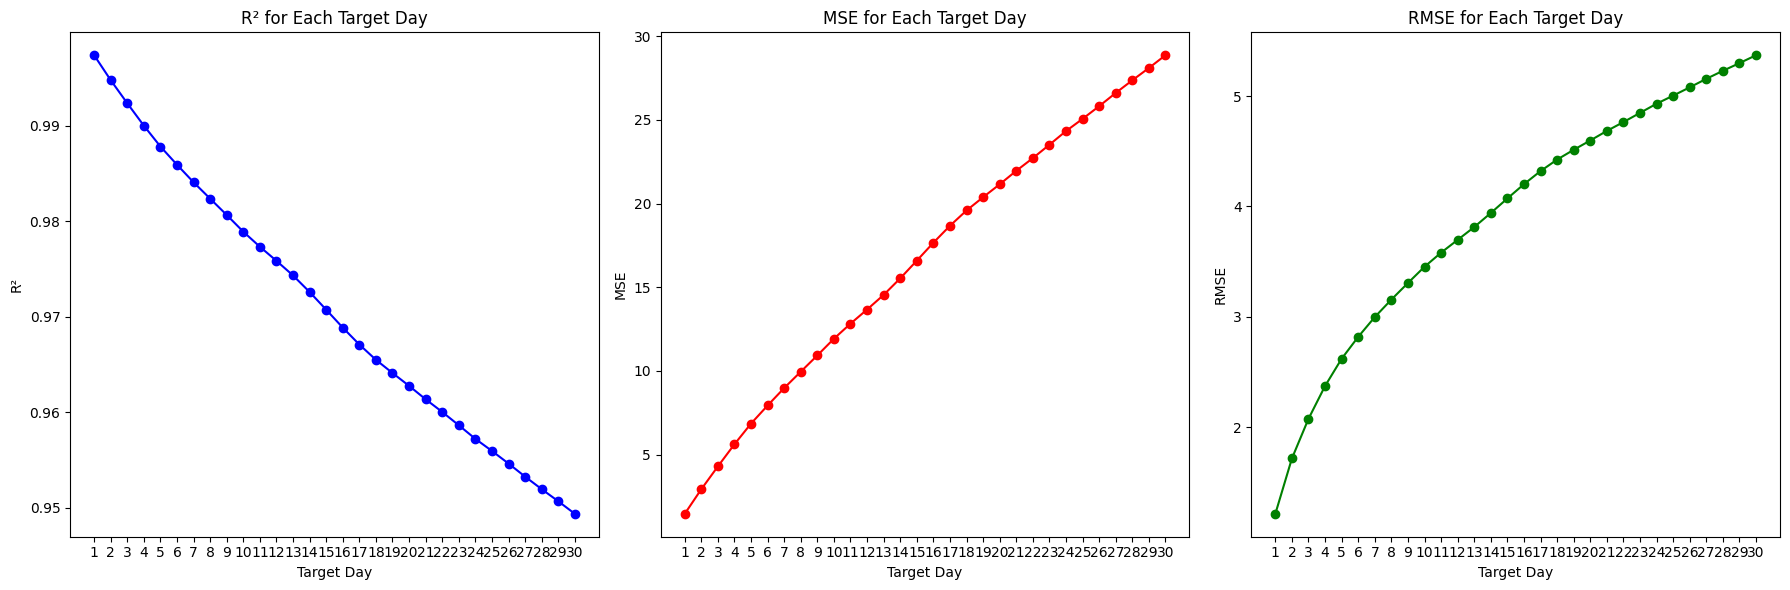

In [795]:
import matplotlib.pyplot as plt

# Initialize lists to store performance metrics for each target day
r2_scores = []
mse_values = []
rmse_values = []

# Extract metrics for each target day
for day_index, estimator in enumerate(model.estimators_):
    # Calculate predictions
    y_pred = estimator.predict(X_train_dropped)
    
    # Calculate performance metrics
    mse = mean_squared_error(y_train_dropped.iloc[:, day_index], y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_train_dropped.iloc[:, day_index], y_pred)
    
    # Append metrics to the respective lists
    mse_values.append(mse)
    rmse_values.append(rmse)
    r2_scores.append(r2)

# Create a DataFrame to hold the metrics for each target day
metrics_df = pd.DataFrame({
    'Target Day': [f'{i+1}' for i in range(len(r2_scores))],
    'R^2': r2_scores,
    'MSE': mse_values,
    'RMSE': rmse_values
})

# Set plot size
plt.figure(figsize=(18, 6))

# Plot R²
plt.subplot(1, 3, 1)
plt.plot(metrics_df['Target Day'], metrics_df['R^2'], color='blue', marker='o')
plt.title('R² for Each Target Day')
plt.xlabel('Target Day')
plt.ylabel('R²')

# Plot MSE
plt.subplot(1, 3, 2)
plt.plot(metrics_df['Target Day'], metrics_df['MSE'], color='red', marker='o')
plt.title('MSE for Each Target Day')
plt.xlabel('Target Day')
plt.ylabel('MSE')

# Plot RMSE
plt.subplot(1, 3, 3)
plt.plot(metrics_df['Target Day'], metrics_df['RMSE'], color='green', marker='o')
plt.title('RMSE for Each Target Day')
plt.xlabel('Target Day')
plt.ylabel('RMSE')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()


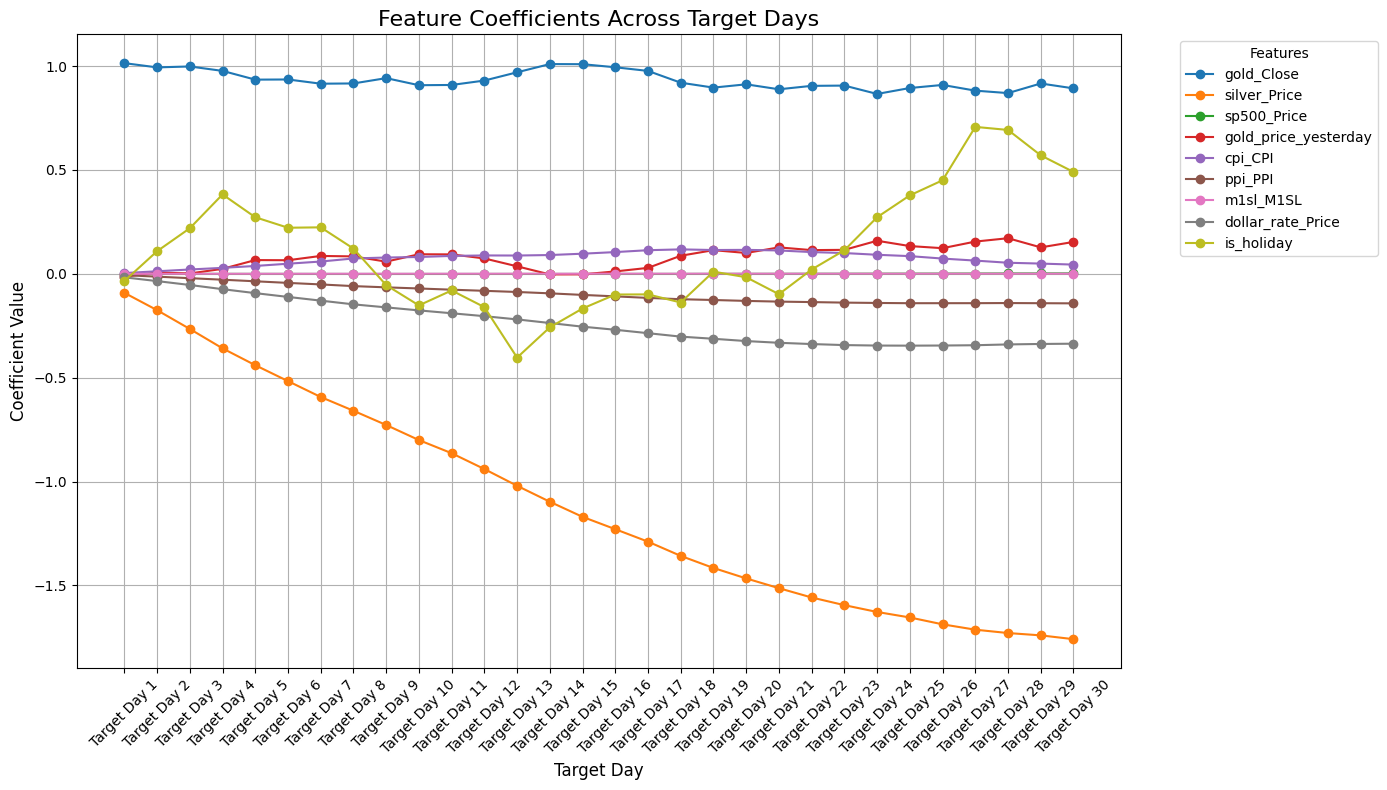

In [788]:
import matplotlib.pyplot as plt

# Create a DataFrame to store the coefficients for each target day
coefficients_df = pd.DataFrame()

# Loop through each day's model and extract the coefficients for the relevant features
for day_index, estimator in enumerate(model.estimators_):
    # Get coefficients as a Series with feature names
    coefficients = pd.Series(estimator.coef_, index=feature_names)
    
    # Add the coefficients for the target day to the DataFrame
    coefficients_df[f'Target Day {day_index + 1}'] = coefficients

# Plot the coefficients for each feature across target days
plt.figure(figsize=(14, 8))

# Loop over the rows (features) and plot them
for feature in coefficients_df.index:
    plt.plot(coefficients_df.columns, coefficients_df.loc[feature, :], label=feature, marker='o')

# Add labels and title
plt.title('Feature Coefficients Across Target Days', fontsize=16)
plt.xlabel('Target Day', fontsize=12)
plt.ylabel('Coefficient Value', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Features', bbox_to_anchor=(1.05, 1), loc='upper left')

# Display the plot
plt.grid(True)
plt.tight_layout()
plt.show()

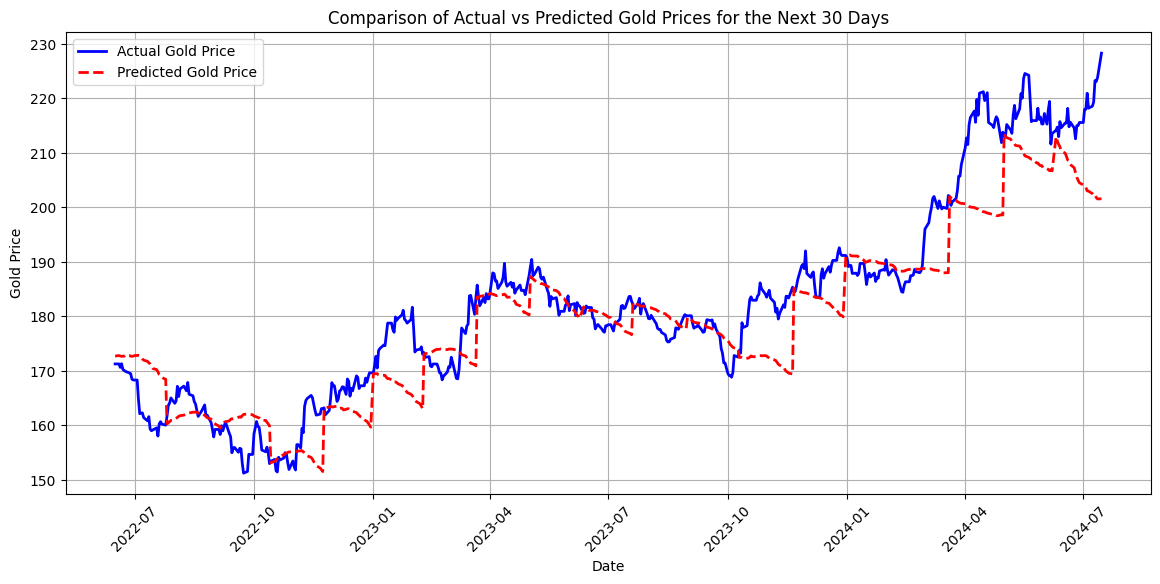

<Figure size 1400x1000 with 0 Axes>

In [647]:
import matplotlib.pyplot as plt
import pandas as pd
model = MultiOutputRegressor(LinearRegression())
model.fit(X_train_dropped, y_train_dropped)
predictions = model.predict(X_test_dropped)

def plot_results(predictions, num_of_days=6):
    # Extract the actual values for the test period (y_test_dropped)
    actual_values = y_test_dropped.iloc[:, 0].values  # Assuming first column has actual values (e.g., 'target_day_1')
    actual_dates = y_test_dropped.index

    # Prepare lists for concatenating predicted values and corresponding dates
    predicted_values = []
    predicted_dates = []
    predictions_df = pd.DataFrame(predictions, index=y_test_dropped.index, 
                                  columns=[f'predicted_day_{i+1}' for i in range(predictions.shape[1])])

    # Create the plot for actual values
    plt.figure(figsize=(14, 6))
    plt.plot(actual_dates, actual_values, label='Actual Gold Price', color='blue', linewidth=2)
    true_values_length = len(y_test_dropped)
    # Loop through the predictions and plot them in chunks of `num_of_days`
    for i in range(0, len(predictions_df), num_of_days):
        # Check if this chunk is smaller than num_of_days
        end_index = min(i + num_of_days, len(predictions_df))
        # Take the current chunk, ensuring we don't go out of bounds
        predicted_chunk = predictions_df.iloc[i, :]  # Grab the chunk (first row if it's the first row)
        # Add to the list of predicted values
        predicted_values.extend(predicted_chunk.values.flatten())  # Flatten to avoid nested lists
        predicted_dates.extend(y_test_dropped.index[i:end_index])
    predicted_values = predicted_values[:true_values_length]
    predicted_dates = predicted_dates[:true_values_length]

    # Plot the predicted values as a single line
    plt.plot(predicted_dates, predicted_values, label='Predicted Gold Price', color='red', linestyle='--', linewidth=2)
    
    plt.title(f'Comparison of Actual vs Predicted Gold Prices for the Next {num_of_days} Days')
    plt.xlabel('Date')
    plt.ylabel('Gold Price')
    plt.legend(loc='upper left')
    
    plt.xticks(rotation=45)  # Rotate x-axis labels for readability
    plt.grid()
    plt.show()
    
    # Plot residuals and R² for each target day
    plt.figure(figsize=(14, 10))
    
    r2_scores = []  # To store R² scores for each target day
  
plot_results(predictions, num_of_days=num_days)

In [663]:
predictions
"""172.693109
171.298066
171.775276
171.794060
170.829339
171.685562
170.830549
170.593272
"""
172.67196921 171.26158515 171.72604102 171.79525998 170.78366696
 171.59574595 170.74811047 170.48903467 170.37325297 170.1681525
 170.01198229 169.25655009 169.16700995 169.46179241 169.62460519

array([[172.70541615, 172.73991993, 172.81290033, ..., 169.05827555,
        168.78902518, 168.43994799],
       [171.26760788, 171.29773261, 171.22434066, ..., 167.93733704,
        167.61064875, 167.41241499],
       [171.31177788, 171.4516063 , 171.57604113, ..., 168.85227702,
        168.53325753, 168.12401335],
       ...,
       [222.42386236, 221.54106875, 220.67461506, ..., 208.1758639 ,
        208.43843305, 208.34994067],
       [222.22308468, 221.47595738, 220.56533207, ..., 209.40204144,
        209.42621754, 209.53274674],
       [223.06152324, 222.22440759, 221.28915019, ..., 210.43522618,
        210.67980368, 210.74668106]])

ValueError: 'darkpurple' is not a valid value for color: supported inputs are (r, g, b) and (r, g, b, a) 0-1 float tuples; '#rrggbb', '#rrggbbaa', '#rgb', '#rgba' strings; named color strings; string reprs of 0-1 floats for grayscale values; 'C0', 'C1', ... strings for colors of the color cycle; and pairs combining one of the above with an alpha value

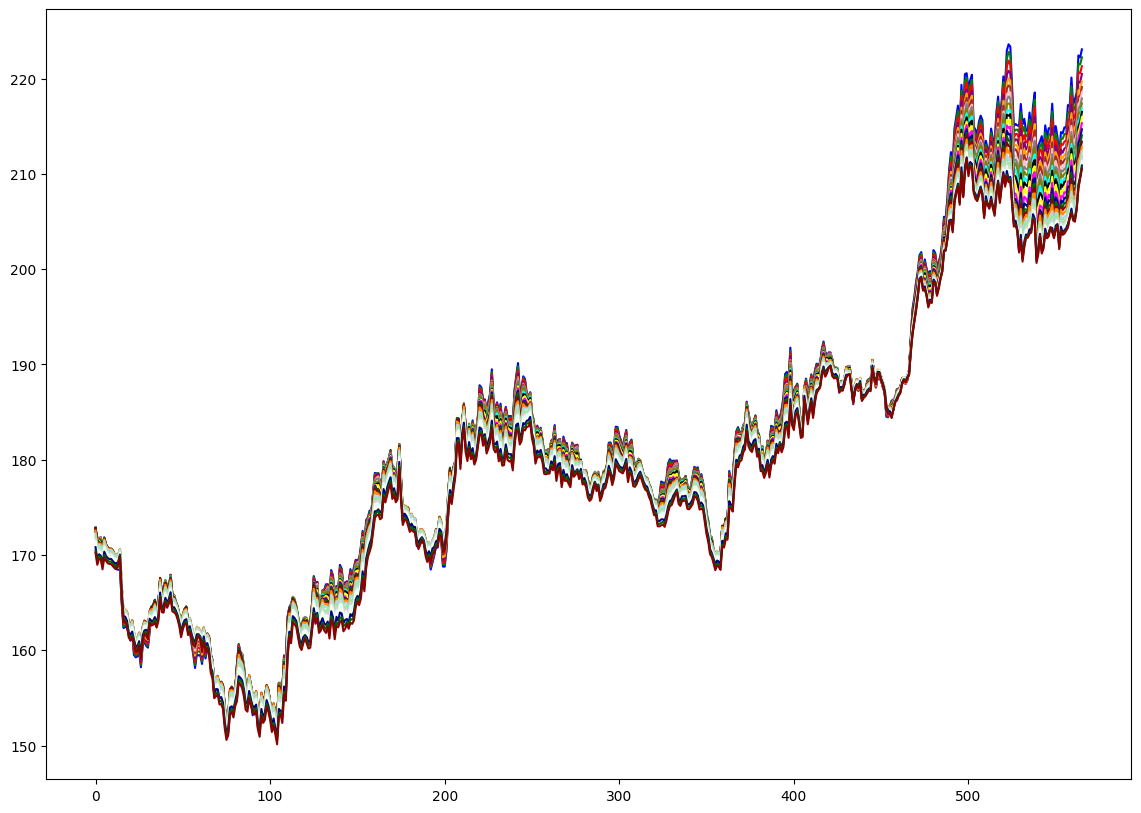

In [682]:
plt.figure(figsize=(14, 10))
#list of 30 colors

colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink', 'gray', 'olive', 'cyan', 'black', 'yellow', 'magenta', 'darkblue', 'darkgreen', 'darkred', 'darkorange','lightblue', 'lightgreen',  'lightgray', 'lightcyan', 'lightyellow', 'darkblue', 'darkgreen', 'darkred', 'darkpurple', 'darkorange', 'darkbrown', 'darkpink', 'darkgray', 'darkolive', 'darkcyan', 'darkblack', 'darkyellow', 'darkmagenta', 'lightblue', 'lightgreen', 'lightred', 'lightpurple', 'lightorange', 'lightbrown', 'lightpink', 'lightgray', 'lightolive', 'lightcyan', 'lightblack', 'lightyellow', 'lightmagenta', 'darkblue', 'darkgreen', 'darkred', 'darkpurple', 'darkorange', 'darkbrown', 'darkpink', 'darkgray', 'darkolive', 'darkcyan', 'darkblack', 'darkyellow', 'darkmagenta', 'lightblue', 'lightgreen', 'lightred', 'lightpurple', 'lightorange', 'lightbrown', 'lightpink', 'lightgray', 'lightolive', 'lightcyan', 'lightblack', 'lightyellow', 'lightmagenta', 'darkblue', 'darkgreen', 'darkred', 'darkpurple', 'darkorange', 'darkbrown', 'darkpink', 'darkgray', 'darkolive', 'darkcyan', 'darkblack', 'darkyellow', 'darkmagenta', 'lightblue', 'lightgreen', 'lightred', 'lightpurple', 'lightorange', 'lightbrown', 'lightpink', 'lightgray', 'lightolive', 'lightcyan', 'lightblack', 'lightyellow', 'lightmagenta', 'darkblue', 'darkgreen', 'darkred', 'darkpurple', 'darkorange', 'darkbrown', 'darkpink', 'darkgray', 'darkolive', 'darkcyan', 'darkblack', 'darkyellow', 'darkmagenta', 'lightblue', 'lightgreen', 'lightred', 'lightpurple', 'lightorange', 'lightbrown', 'lightpink', 'lightgray', 'lightolive', 'lightcyan', 'lightblack', 'lightyellow', 'lightmagenta', 'darkblue', 'darkgreen', 'darkred', 'darkpurple', 'darkorange', 'darkbrown', 'darkpink', 'darkgray', 'darkolive', 'darkcyan', 'darkblack', 'darkyellow', 'darkmagenta', 'lightblue', 'lightgreen', 'lightred']
for i in range(29):
    plt.plot(predictions[:, i], label=f'Predicted Gold Price - Model of Day {i}', color=colors[i])
plt.legend(loc='upper left')
plt.show()

In [685]:
y_test_dropped

,target_day_1,target_day_2,target_day_3,target_day_4,target_day_5,target_day_6,target_day_7,target_day_8,target_day_9,target_day_10,...,target_day_21,target_day_22,target_day_23,target_day_24,target_day_25,target_day_26,target_day_27,target_day_28,target_day_29,target_day_30
Date,,,,,,,,,,,,,,,,,,,,,
2022-06-16,171.270004,171.270004,171.270004,170.630005,171.309998,170.259995,170.089996,169.899994,169.619995,169.490005,...,161.600006,159.330002,159.009995,159.160004,159.539993,158.039993,160.270004,160.669998,160.229996,160.039993
2022-06-17,171.270004,171.270004,170.630005,171.309998,170.259995,170.089996,169.899994,169.619995,169.490005,168.460007,...,159.330002,159.009995,159.160004,159.539993,158.039993,160.270004,160.669998,160.229996,160.039993,161.669998
2022-06-19,171.270004,170.630005,171.309998,170.259995,170.089996,169.899994,169.619995,169.490005,168.460007,168.320007,...,159.009995,159.160004,159.539993,158.039993,160.270004,160.669998,160.229996,160.039993,161.669998,163.639999
2022-06-20,170.630005,171.309998,170.259995,170.089996,169.899994,169.619995,169.490005,168.460007,168.320007,168.320007,...,159.160004,159.539993,158.039993,160.270004,160.669998,160.229996,160.039993,161.669998,163.639999,164.100006
2022-06-21,171.309998,170.259995,170.089996,169.899994,169.619995,169.490005,168.460007,168.320007,168.320007,168.320007,...,159.539993,158.039993,160.270004,160.669998,160.229996,160.039993,161.669998,163.639999,164.100006,165.029999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-09,219.360001,223.250000,223.110001,223.830002,228.289993,227.229996,225.779999,221.729996,221.800003,222.580002,...,220.699997,220.550003,224.009995,224.559998,228.410004,228.059998,226.199997,226.910004,231.990005,231.610001
2024-07-10,223.250000,223.110001,223.830002,228.289993,227.229996,225.779999,221.729996,221.800003,222.580002,221.800003,...,220.550003,224.009995,224.559998,228.410004,228.059998,226.199997,226.910004,231.990005,231.610001,232.460007
2024-07-11,223.110001,223.830002,228.289993,227.229996,225.779999,221.729996,221.800003,222.580002,221.800003,218.330002,...,224.009995,224.559998,228.410004,228.059998,226.199997,226.910004,231.990005,231.610001,232.460007,232.149994


In [710]:
predictions

array([[172.70541615, 172.73991993, 172.81290033, ..., 169.05827555,
        168.78902518, 168.43994799],
       [171.26760788, 171.29773261, 171.22434066, ..., 167.93733704,
        167.61064875, 167.41241499],
       [171.31177788, 171.4516063 , 171.57604113, ..., 168.85227702,
        168.53325753, 168.12401335],
       ...,
       [222.42386236, 221.54106875, 220.67461506, ..., 208.1758639 ,
        208.43843305, 208.34994067],
       [222.22308468, 221.47595738, 220.56533207, ..., 209.40204144,
        209.42621754, 209.53274674],
       [223.06152324, 222.22440759, 221.28915019, ..., 210.43522618,
        210.67980368, 210.74668106]])

In [691]:
y_test_dropped

,target_day_1,target_day_2,target_day_3,target_day_4,target_day_5,target_day_6,target_day_7,target_day_8,target_day_9,target_day_10,...,target_day_21,target_day_22,target_day_23,target_day_24,target_day_25,target_day_26,target_day_27,target_day_28,target_day_29,target_day_30
Date,,,,,,,,,,,,,,,,,,,,,
2022-06-16,171.270004,171.270004,171.270004,170.630005,171.309998,170.259995,170.089996,169.899994,169.619995,169.490005,...,161.600006,159.330002,159.009995,159.160004,159.539993,158.039993,160.270004,160.669998,160.229996,160.039993
2022-06-17,171.270004,171.270004,170.630005,171.309998,170.259995,170.089996,169.899994,169.619995,169.490005,168.460007,...,159.330002,159.009995,159.160004,159.539993,158.039993,160.270004,160.669998,160.229996,160.039993,161.669998
2022-06-19,171.270004,170.630005,171.309998,170.259995,170.089996,169.899994,169.619995,169.490005,168.460007,168.320007,...,159.009995,159.160004,159.539993,158.039993,160.270004,160.669998,160.229996,160.039993,161.669998,163.639999
2022-06-20,170.630005,171.309998,170.259995,170.089996,169.899994,169.619995,169.490005,168.460007,168.320007,168.320007,...,159.160004,159.539993,158.039993,160.270004,160.669998,160.229996,160.039993,161.669998,163.639999,164.100006
2022-06-21,171.309998,170.259995,170.089996,169.899994,169.619995,169.490005,168.460007,168.320007,168.320007,168.320007,...,159.539993,158.039993,160.270004,160.669998,160.229996,160.039993,161.669998,163.639999,164.100006,165.029999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-09,219.360001,223.250000,223.110001,223.830002,228.289993,227.229996,225.779999,221.729996,221.800003,222.580002,...,220.699997,220.550003,224.009995,224.559998,228.410004,228.059998,226.199997,226.910004,231.990005,231.610001
2024-07-10,223.250000,223.110001,223.830002,228.289993,227.229996,225.779999,221.729996,221.800003,222.580002,221.800003,...,220.550003,224.009995,224.559998,228.410004,228.059998,226.199997,226.910004,231.990005,231.610001,232.460007
2024-07-11,223.110001,223.830002,228.289993,227.229996,225.779999,221.729996,221.800003,222.580002,221.800003,218.330002,...,224.009995,224.559998,228.410004,228.059998,226.199997,226.910004,231.990005,231.610001,232.460007,232.149994


In [802]:
predictions

array([[172.70541615, 172.73991993, 172.81290033, ..., 169.05827555,
        168.78902518, 168.43994799],
       [171.26760788, 171.29773261, 171.22434066, ..., 167.93733704,
        167.61064875, 167.41241499],
       [171.31177788, 171.4516063 , 171.57604113, ..., 168.85227702,
        168.53325753, 168.12401335],
       ...,
       [222.42386236, 221.54106875, 220.67461506, ..., 208.1758639 ,
        208.43843305, 208.34994067],
       [222.22308468, 221.47595738, 220.56533207, ..., 209.40204144,
        209.42621754, 209.53274674],
       [223.06152324, 222.22440759, 221.28915019, ..., 210.43522618,
        210.67980368, 210.74668106]])

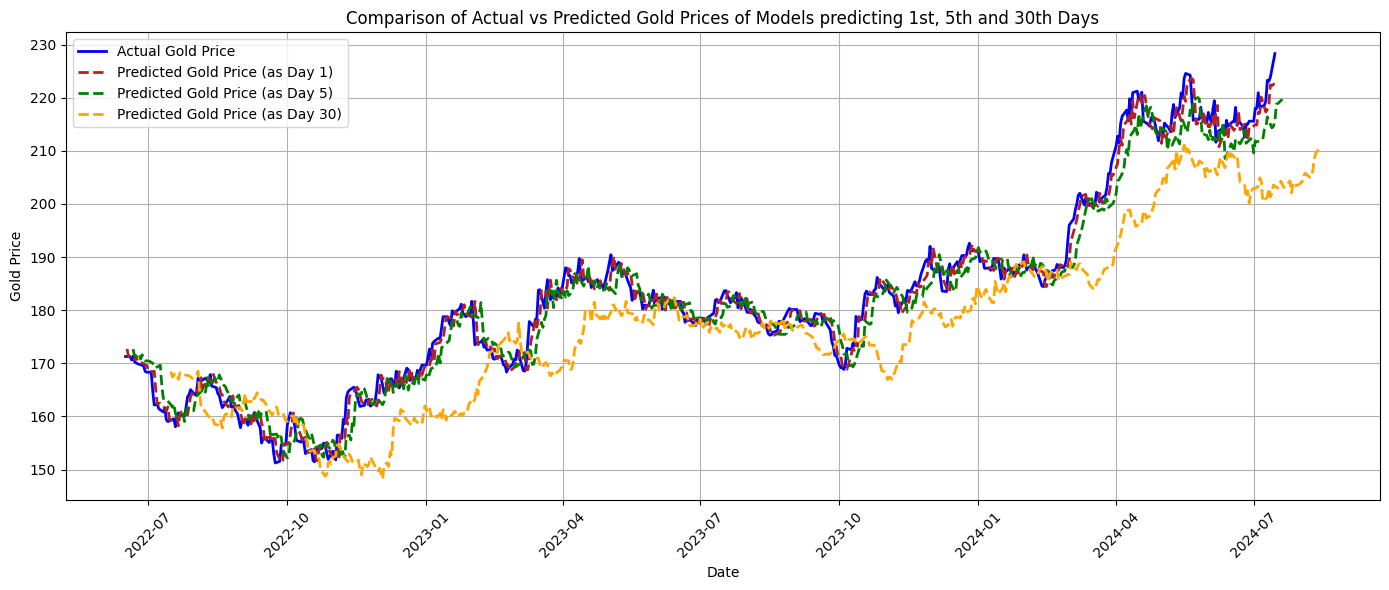

In [709]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor

model = MultiOutputRegressor(LinearRegression())
model.fit(X_train_dropped, y_train_dropped)
predictions = model.predict(X_test_dropped)

def plot_results(predictions, model_numbers=[1, 5, 30]):
    # Prepare lists for actual and predicted values
    plt.figure(figsize=(14, 6))

    # Plot the actual values (same for all target days)
    actual_values = y_test_dropped.iloc[:, 0].values  # Assuming the first column is the actual values
    actual_dates = y_test_dropped.index
    plt.plot(actual_dates, actual_values, label='Actual Gold Price', color='blue', linewidth=2)
    
    # Color choices for different target days
    colors = ['#B22222', 'green', 'orange']


    i = 0

    # Plot the predicted values for each target day (1, 5, 30)
    for model_number in model_numbers:
        predicted_values = predictions[:, model_number - 1]  # Get the predictions for the target day (model_number)
        
        # Shift the predicted dates by the number of days in model_number
        shifted_dates = y_test_dropped.index + pd.Timedelta(days=model_number)  # Shift dates forward by model_number days

        # Plot the predicted values for this model_number
        plt.plot(shifted_dates, predicted_values, linestyle='--', color=colors[i], label=f'Predicted Gold Price (as Day {model_number})', linewidth=2)
        i += 1

    # Title and labels for the plot
    plt.title('Comparison of Actual vs Predicted Gold Prices of Models predicting 1st, 5th and 30th Days')
    plt.xlabel('Date')
    plt.ylabel('Gold Price')
    plt.legend(loc='upper left')
    plt.xticks(rotation=45)  # Rotate x-axis labels for readability
    plt.grid()
    plt.tight_layout()
    plt.show()

# Call the function for the target days you want to plot (e.g., Day 1, Day 5, Day 30)
plot_results(predictions, model_numbers=[1, 5, 30])


actual
[171.270004 171.270004 171.270004 170.630005 171.309998 170.259995
 170.089996 169.899994 169.619995 169.490005 168.460007 168.320007
 168.320007 168.320007 164.75     162.139999 162.229996 162.300003
 161.429993 160.830002 161.600006 159.330002 159.009995 159.160004
 159.539993 158.039993 160.270004 160.669998 160.229996 160.039993
 161.669998 163.639999 164.100006 165.029999 164.050003 164.449997
 167.169998 165.289993 166.690002 167.199997 166.779999 166.339996
 167.869995 165.710007 165.419998 164.350006 163.919998 162.720001
 161.639999 162.770004 163.25     163.75     161.759995 161.860001
 160.509995 159.270004 157.869995 159.259995 159.259995 159.259995
 158.330002 159.940002 158.979996 159.820007 160.630005 158.539993
 157.929993 154.979996 155.839996 155.960007 155.070007 155.789993
 155.699997 153.009995 151.229996 151.539993 154.690002 154.660004
 154.669998 154.669998 158.429993 160.699997 159.809998 159.630005
 157.880005 155.479996 155.160004 155.990005 154.910004

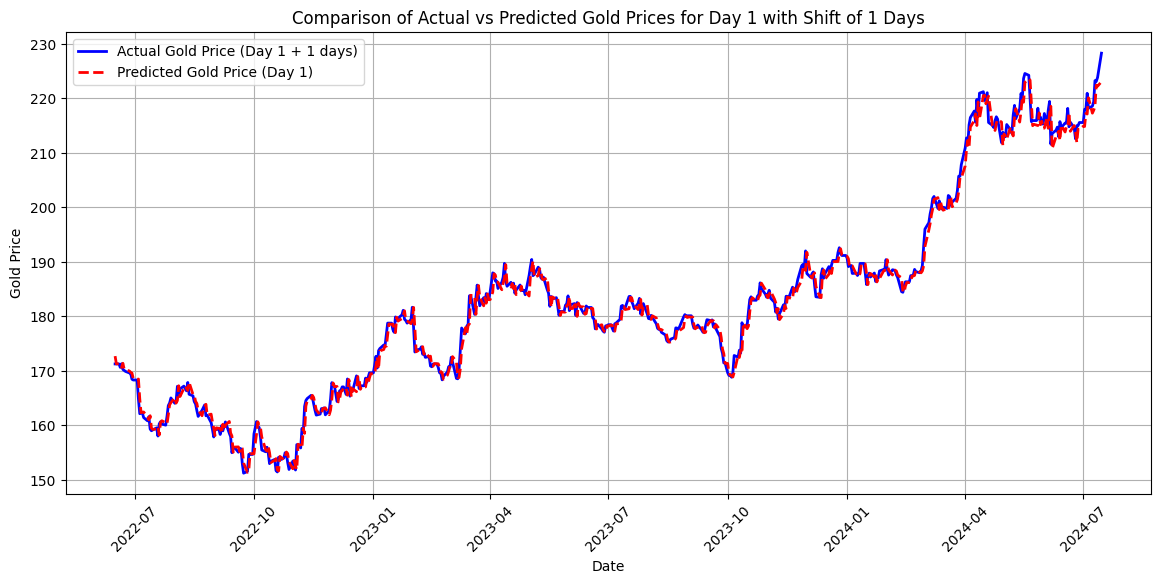

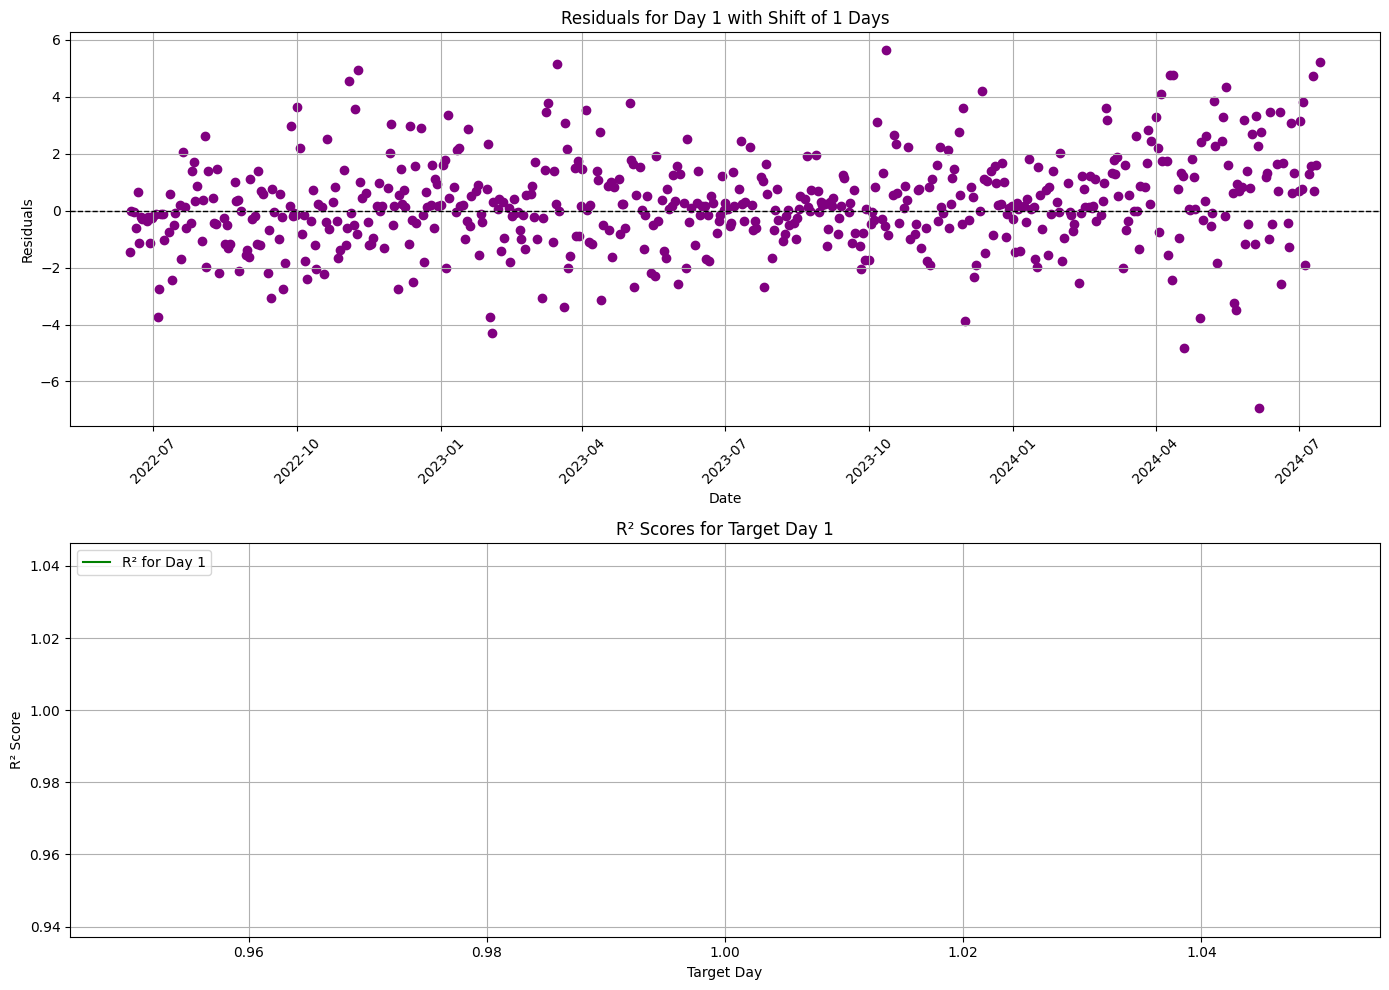

In [690]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import r2_score

model = MultiOutputRegressor(LinearRegression())
model.fit(X_train_dropped, y_train_dropped)
predictions = model.predict(X_test_dropped)

def plot_results(predictions):
    # Extract the actual values for the test period (y_test_dropped)
    actual_values = y_test_dropped.iloc[:, model_number - 1].values  # Actual values for the target day (e.g., 'target_day_7')
    actual_dates = y_test_dropped.index
    print('actual')
    print(actual_values)

    # Prepare lists to store predicted and actual values
    predicted_values = predictions[:, model_number - 1]  # Get the predictions for the target day (model_number)
    predicted_dates = y_test_dropped.index  # Use the same dates as actuals
    print('predicted')
    print(predicted_values)

    # Get the actual values for the future day X (model_number), shift by model_number
    # Create the plot for actual values and predicted values
    plt.figure(figsize=(14, 6))
    
    # Plot the actual values for the future target day X
    plt.plot(actual_dates, actual_values, label=f'Actual Gold Price (Day {model_number} + {model_number} days)', color='blue', linewidth=2)
    
    # Plot the predicted values for the target day
    plt.plot(predicted_dates, predicted_values, label=f'Predicted Gold Price (Day {model_number})', color='red', linestyle='--', linewidth=2)
    
    # Title and labels for the plot
    plt.title(f'Comparison of Actual vs Predicted Gold Prices for Day {model_number} with Shift of {model_number} Days')
    plt.xlabel('Date')
    plt.ylabel('Gold Price')
    plt.legend(loc='upper left')
    plt.xticks(rotation=45)  # Rotate x-axis labels for readability
    plt.grid()
    plt.show()

    # Plot residuals and R² for each target day
    plt.figure(figsize=(14, 10))

    r2_scores = []  # To store R² scores for the target day
    residuals = actual_values - predicted_values  # Calculate residuals for the shifted actuals

    # Compute R² score for this target day
    r2 = r2_score(actual_values, predicted_values)
    r2_scores.append(r2)
    
    # Plot residuals for the target day
    plt.subplot(2, 1, 1)  # Plot residuals in the first subplot
    plt.scatter(actual_dates, residuals, color='purple')
    plt.axhline(0, color='black', linestyle='--', linewidth=1)
    plt.title(f'Residuals for Day {model_number} with Shift of {model_number} Days')
    plt.xlabel('Date')
    plt.ylabel('Residuals')
    plt.xticks(rotation=45)
    plt.grid()

    # Plot R² score for this target day
    plt.subplot(2, 1, 2)  # Plot R² score in the second subplot
    plt.plot(range(1, model_number + 1), r2_scores, label=f'R² for Day {model_number}', color='green')
    plt.title(f'R² Scores for Target Day {model_number}')
    plt.xlabel('Target Day')
    plt.ylabel('R² Score')
    plt.legend(loc='upper left')
    plt.grid()
    
    plt.tight_layout()
    plt.show()

# Call the function for the target day you want to plot (e.g., Day 7)
plot_results(predictions)

In [648]:
import pandas as pd

def create_predictions_df(predictions, num_of_days=30):
    # Initialize an empty list to store concatenated predictions
    predictions_list = []
    
    # Loop over each target day (i.e., column in predictions)
    for i in range(predictions.shape[1]):
        # For each target day, collect predictions by jumping `num_of_days`
        day_predictions = []
        for j in range(0, len(predictions), num_of_days):
            end_index = min(j + num_of_days, len(predictions))
            day_predictions.extend(predictions[j:end_index, i])  # Concatenate predictions
            
        predictions_list.append(day_predictions)
    
    # Convert the concatenated predictions list to a DataFrame
    predictions_df = pd.DataFrame(predictions_list).transpose()
    
    # Set column names for target days (target_day_1, target_day_2, ...)
    predictions_df.columns = [f'target_day_{i+1}' for i in range(predictions.shape[1])]
    
    return predictions_df

# Now, we can create the predictions DataFrame
predictions_df = create_predictions_df(predictions, num_of_days=30)

# Display the predictions DataFrame
print(predictions_df)

# Display the predictions DataFrame
predictions_df


     target_day_1  target_day_2  target_day_3  target_day_4  target_day_5  \
0      172.705416    172.739920    172.812900    172.718159    172.671969   
1      171.267608    171.297733    171.224341    171.223946    171.261585   
2      171.311778    171.451606    171.576041    171.863464    171.726041   
3      171.252867    171.456888    171.674093    171.879546    171.795260   
4      170.645829    170.680483    170.719962    170.760322    170.783667   
..            ...           ...           ...           ...           ...   
561    217.799085    216.955157    216.083406    215.359999    214.576376   
562    218.524577    217.810599    217.112333    216.241259    215.558289   
563    222.423862    221.541069    220.674615    219.682621    218.766320   
564    222.223085    221.475957    220.565332    219.582060    218.893055   
565    223.061523    222.224408    221.289150    220.481162    219.698625   

     target_day_6  target_day_7  target_day_8  target_day_9  target_day_10 

,target_day_1,target_day_2,target_day_3,target_day_4,target_day_5,target_day_6,target_day_7,target_day_8,target_day_9,target_day_10,...,target_day_21,target_day_22,target_day_23,target_day_24,target_day_25,target_day_26,target_day_27,target_day_28,target_day_29,target_day_30
0,172.705416,172.739920,172.812900,172.718159,172.671969,172.693109,172.690595,172.903585,172.838364,172.697502,...,171.483290,171.266155,170.814708,170.435908,170.235778,169.832102,169.291937,169.058276,168.789025,168.439948
1,171.267608,171.297733,171.224341,171.223946,171.261585,171.298066,171.456384,171.536716,171.413829,171.471344,...,170.308650,169.896043,169.550880,169.354361,168.965475,168.477543,168.211353,167.937337,167.610649,167.412415
2,171.311778,171.451606,171.576041,171.863464,171.726041,171.775276,171.886183,171.783152,171.644399,171.534584,...,170.443418,170.179641,170.064877,169.886271,169.591291,169.308370,169.308762,168.852277,168.533258,168.124013
3,171.252867,171.456888,171.674093,171.879546,171.795260,171.794060,171.807942,171.846728,171.634356,171.445651,...,170.310530,170.187114,169.919246,169.733660,169.554689,169.278309,169.101086,168.792468,168.359278,167.915102
4,170.645829,170.680483,170.719962,170.760322,170.783667,170.829339,170.888082,170.970945,170.916797,170.885787,...,169.693524,169.397795,169.093767,168.806452,168.496753,168.137200,167.805222,167.509954,167.234055,166.953147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
561,217.799085,216.955157,216.083406,215.359999,214.576376,214.004064,213.418854,212.714406,212.254039,211.677964,...,205.885558,205.483162,205.459402,205.215727,204.979156,204.869867,204.930856,204.790506,205.040484,205.013395
562,218.524577,217.810599,217.112333,216.241259,215.558289,214.909883,214.175476,213.747125,213.174293,212.479283,...,206.885135,206.758651,206.472251,206.243082,206.247666,206.165559,205.927341,206.086850,206.163118,206.105156
563,222.423862,221.541069,220.674615,219.682621,218.766320,218.091058,217.346874,216.798973,216.267826,215.493115,...,209.376304,209.129222,208.880543,208.540194,208.509344,208.374546,208.147313,208.175864,208.438433,208.349941
564,222.223085,221.475957,220.565332,219.582060,218.893055,218.200425,217.599410,217.153469,216.454651,215.885359,...,210.309137,210.024929,209.679492,209.620960,209.537679,209.275792,209.159981,209.402041,209.426218,209.532747


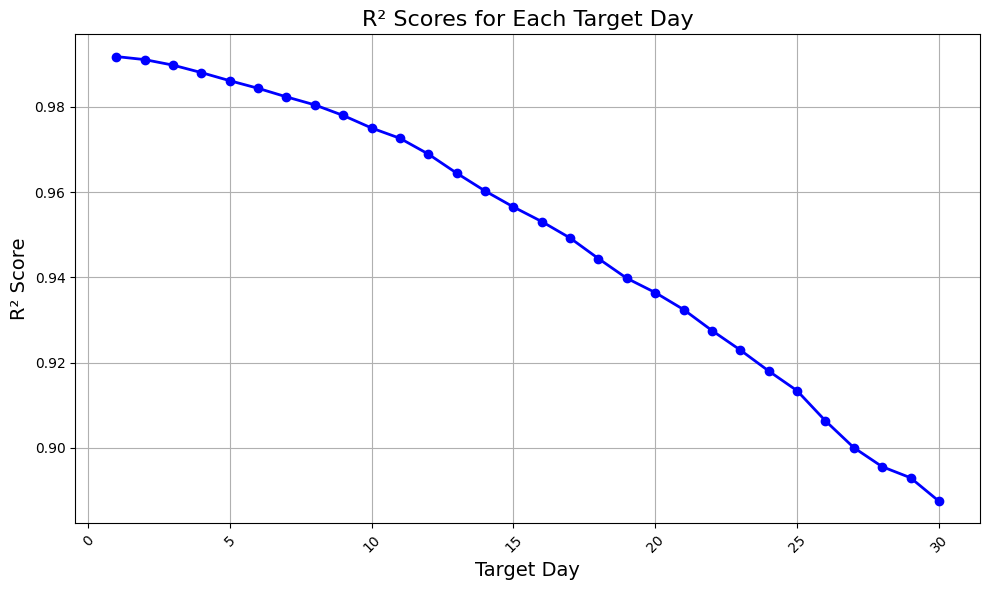

,target_day,R²
0,1,0.991756
1,2,0.991044
2,3,0.989749
3,4,0.987999
4,5,0.986101
5,6,0.984313
6,7,0.982304
7,8,0.980426
8,9,0.977947
9,10,0.975008


In [650]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

def calculate_r2_for_each_day(predictions, y_test_dropped, num_of_days):
    r2_scores = []

    # Loop through each target day (from 1 to num_of_days)
    for day in range(num_of_days):
        # Get the column for the target day
        predicted_values_for_day = predictions[:, day]
        
        # Get the actual values for the target day
        actual_values_for_day = y_test_dropped.iloc[:, 0].values  # Assuming one column of actual values

        # Calculate R² score for the target day
        r2 = r2_score(actual_values_for_day, predicted_values_for_day)
        
        # Append the R² score for this day to the list
        r2_scores.append({'target_day': day + 1, 'R²': r2})

    # Convert to DataFrame for easier plotting
    r2_df = pd.DataFrame(r2_scores)
    return r2_df

def plot_r2_for_each_day(r2_df):
    # Plot R² scores
    plt.figure(figsize=(10, 6))
    plt.plot(r2_df['target_day'], r2_df['R²'], marker='o', color='b', linestyle='-', linewidth=2, markersize=6)
    
    # Set labels and title
    plt.title('R² Scores for Each Target Day', fontsize=16)
    plt.xlabel('Target Day', fontsize=14)
    plt.ylabel('R² Score', fontsize=14)
    
    # Add grid and improve layout
    plt.grid(True)
    plt.xticks(rotation=45)
    
    # Show plot
    plt.tight_layout()
    plt.show()

# Assuming you have the predictions from your model
# predictions = model.predict(X_test_dropped)  # This is the result of the model prediction
# y_test_dropped = actual values from the test set

# Example usage
r2_df = calculate_r2_for_each_day(predictions, y_test_dropped, num_days)
plot_r2_for_each_day(r2_df)
r2_df

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Calculate performance metrics
rmse = np.sqrt(mean_squared_error(y_test_dropped, predictions))
mae = mean_absolute_error(y_test_dropped, predictions)
r2 = r2_score(y_test_dropped, predictions)

print(f"Root Mean Square Error: {rmse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")
print(f"R² Score: {r2:.2f}")

# Plot residuals
residuals = y_test_dropped - predictions

# Assuming you have residuals as 'residuals' DataFrame with target_day_1, target_day_2, ..., target_day_30
# Create a plot for each target day
target_days = [f'target_day_{i}' for i in range(1, 31)]

# Set up the figure and axes for subplots
fig, axes = plt.subplots(6, 5, figsize=(15, 12))  # Adjust the number of rows and columns as needed
axes = axes.flatten()

# Loop over each target day and plot residuals for that day
for i, target_day in enumerate(target_days):
    residuals_day = residuals[target_day]
    
    axes[i].scatter(y_test_dropped.index, residuals_day, color='purple')
    axes[i].axhline(0, color='black', linestyle='--', linewidth=1)
    axes[i].set_title(f'Residuals for {target_day}')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Residuals')
    axes[i].grid()

# Adjust layout for better spacing between subplots
plt.tight_layout()
plt.show()


In [ ]:
predictions

In [ ]:
y_test_dropped

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score

# Assuming y_test_dropped is the true values and predictions are your model's predictions
# Calculate R² for each target day
r2_scores = []
for i in range(1, 31):  # Assuming 30 target days
    target_column = f'target_day_{i}'
    print(target_column)
    r2 = r2_score(y_test_dropped[target_column], predictions[f'{i-1}'])
    r2_scores.append(r2)

# Plot residuals and R² scores
plt.figure(figsize=(14, 10))

# Loop over each target day
for i in range(1, 31):
    target_column = f'target_day_{i}'
    residuals = y_test_dropped[target_column] - predictions[target_column]
    
    plt.subplot(6, 5, i)  # Create a grid of subplots (6 rows, 5 columns)
    plt.scatter(y_test_dropped.index, residuals, color='purple', alpha=0.5)
    plt.axhline(0, color='black', linestyle='--', linewidth=1)
    plt.title(f"Target Day {i} | R²: {r2_scores[i-1]:.2f}")
    plt.xlabel('Date')
    plt.ylabel('Residuals')
    plt.xticks(rotation=45)
    plt.grid()

plt.tight_layout()
plt.show()


In [ ]:
import statsmodels.api as sm

# Add a constant term to the model (intercept)
X_train_dropped = sm.add_constant(X_train_dropped)
X_test_dropped = sm.add_constant(X_test_dropped)

# Fit the model using statsmodels OLS (Ordinary Least Squares)
model = sm.OLS(y_train_dropped, X_train_dropped).fit()

# Print out the summary of the model
print(model.summary())


In [ ]:
# Lasso Regression - Feature Selection
import pandas as pd
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Assuming you have already created X_train_dropped, X_test_dropped, y_train_dropped, y_test_dropped

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_dropped)
X_test_scaled = scaler.transform(X_test_dropped)

# Initialize the Lasso model with a chosen alpha (regularization strength)
alpha = 0.1  # You may need to adjust this value
lasso_model = Lasso(alpha=alpha)

# Fit the Lasso model
lasso_model.fit(X_train_scaled, y_train_dropped)

# Predictions
y_pred = lasso_model.predict(X_test_scaled)

# Calculate and print evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test_dropped, y_pred))
mae = mean_absolute_error(y_test_dropped, y_pred)

print(f"Root Mean Square Error: {rmse}")
print(f"Mean Absolute Error: {mae}")

# Get the coefficients and the corresponding feature names
coef = pd.Series(lasso_model.coef_, index=X_train_dropped.columns)
print("Lasso Coefficients:")
print(coef[coef != 0])  # Print only significant features (non-zero coefficients)

# Optional: Plot the coefficients
plt.figure(figsize=(10, 6))
coef.plot(kind='bar')
plt.title('Lasso Coefficients')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.show()


In [ ]:
X_train_dropped = X_train.dropna()
y_train_dropped = y_train[X_train_dropped.index]

# Drop rows with NaN in X_test and y_test
X_test_dropped = X_test.dropna()
y_test_dropped = y_test.loc[X_test_dropped.index]  # Drop NaNs based on indices in X_test_dropped

# Ensure that y_test_dropped does not contain NaN values
X_test_dropped = X_test_dropped.dropna()
y_test_dropped = y_test_dropped.dropna()

# Check if indices still match after dropping NaNs
common_index = X_test_dropped.index.intersection(y_test_dropped.index)
X_test_dropped = X_test_dropped.loc[common_index]
y_test_dropped = y_test_dropped.loc[common_index]
# Initialize and train the model
model = LinearRegression()
model.fit(X_train_dropped, y_train_dropped)

# Predict on test data
y_pred = model.predict(X_test_dropped)
pred_index = X_test_dropped.index

# Create a DataFrame for predictions
linear_reg_predictions_df = pd.DataFrame(y_pred, index=pred_index, columns=['Predictions'])
# Assuming test_data is the DataFrame with actual values and it has the same index as X_test_dropped
# Combine predictions and actual test data
test_data = y_test_dropped.to_frame()  # Ensure test_data is a DataFrame
linear_reg_predictions_df = test_data.join(linear_reg_predictions_df)
linear_reg_predictions_df.index = linear_reg_predictions_df.index + pd.DateOffset(days=1)

# Evaluate the model
mse = mean_squared_error(y_test_dropped, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_dropped, y_pred)
mae = mean_absolute_error(y_test_dropped, y_pred)

print("Linear Regression Model Summary")
print(f"Intercept: {model.intercept_}")
print(f"Coefficients: {model.coef_}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R2): {r2}")

In [ ]:
with open('modelResults/linear_reg_predictions_df', 'wb') as file:
    # Serialize the object and write it to the file
    pkl.dump(linear_reg_predictions_df, file)

In [ ]:
import pandas as pd

# Assuming `gold_prices` is your DataFrame with actual prices and `predictions` is a Series of predicted prices
gold_prices['Returns'] = gold_prices['gold_price'].pct_change()  # Actual returns
predictions['Returns'] = predictions.pct_change()  # Predicted returns
